#algoeur 2
the predictions from raspberry does not correspond to the prediction when backtesting! there is a overshooting after a buy
solution: log

In [1]:
#Deserialize
import pickle
import pandas as pd
from src.modules.paths import get_project_root
from src.core.features.utils import feature_pipeline, add_domain_features
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
with open("wow_20.pickle" ,'rb') as f:
    model = pickle.load(f)

In [13]:
def backtest(df: pd.DataFrame, model, threshold, target, fee, columns_features, shift_in_preds):
    """"""
    #if target not in df.columns:
    #    raise KeyError(f"{target} not included in columns")
        
    #df_backtesting = df[[target, "open"]].copy()
    df_backtesting = df[["open"]].copy()
    df_backtesting["preds"] = model.predict(df[columns_features])
    
    df_backtesting = add_actions(df_backtesting, threshold, shift_in_preds)
    return evaluate(df_backtesting, fee)
    
    
    
def add_actions(df_backtesting, threshold, shift_in_preds):
    next_action = "buy"
    df_backtesting["action"] = None
    df_backtesting["sum"] = None
    for index, row in df_backtesting.iterrows():
        if index == 0:
            continue
        if (-df_backtesting.iloc[index-shift_in_preds]["preds"] > threshold) and (next_action=="buy"):
            df_backtesting.loc[df_backtesting.index==index, "action"] = "buy"
            next_action = "sell"
        elif (-df_backtesting.iloc[index-shift_in_preds]["preds"] < -threshold) and (next_action=="sell"):
            df_backtesting.loc[df_backtesting.index==index, "action"] = "sell"
            next_action = "buy"
    return df_backtesting

def evaluate(df_backtesting, fee, market_extra=0.0025):
    df_backtesting["sum"] = None
    df_backtesting.loc[(df_backtesting.action=="buy"), "sum"] = -df_backtesting[df_backtesting.action=="buy"].open*(1+fee+market_extra)
    df_backtesting.loc[(df_backtesting.action=="sell"), "sum"] = df_backtesting[df_backtesting.action=="sell"].open*(1-(fee+market_extra))
    if df_backtesting[df_backtesting.action.notnull()].tail(1).action.values[0]=="buy":
        df_backtesting.loc[df_backtesting[df_backtesting.action.notnull()].tail(1).index, ["sum", "action"]] = None
    if df_backtesting[df_backtesting.action.notnull()].tail(1).action.values[0]=="buy":
        raise ValueError("last action cannot be buy")
    n_trades = df_backtesting["sum"].notnull().sum()
    profit = df_backtesting["sum"].sum()/df_backtesting["open"].mean()
    hist_ratio = df_backtesting.tail(1).open.values[0]/df_backtesting.head(1).open.values[0]-1
    return n_trades, profit, hist_ratio, df_backtesting
    
    

In [29]:
df_test = pd.read_csv(get_project_root() / "data" / "historical" / "etheur.csv")

In [31]:
df_test_pro, _ = feature_pipeline(df_test, include_target=True, target_list=[10] )

In [33]:
df_test

,date,time,open,high,low,close,vwap,volume,count
0,2021-09-23 06:25:00,1632378300,2650.11,2650.12,2647.89,2648.69,2649.43,18.785790,22
1,2021-09-23 06:26:00,1632378360,2648.69,2650.02,2648.69,2650.02,2649.89,1.036302,3
2,2021-09-23 06:27:00,1632378420,2650.02,2650.02,2650.02,2650.02,2650.02,0.568392,6
3,2021-09-23 06:28:00,1632378480,2650.02,2650.02,2650.01,2650.01,2650.01,0.616541,5
4,2021-09-23 06:29:00,1632378540,2650.01,2650.02,2650.01,2650.01,2650.01,13.849192,11
...,...,...,...,...,...,...,...,...,...
91435,2021-11-25 18:20:00,1637864400,4034.01,4034.01,4030.01,4030.01,4033.22,6.396920,22
91436,2021-11-25 18:21:00,1637864460,4030.01,4030.01,4027.31,4027.31,4029.36,20.577686,28
91437,2021-11-25 18:22:00,1637864520,4027.32,4027.32,4022.21,4025.04,4023.74,4.121305,24
91438,2021-11-25 18:23:00,1637864580,4025.05,4027.22,4025.05,4026.29,4026.14,5.365511,18


In [32]:
df_test_pro

,date,time,open,high,low,close,vwap,volume,count,open_norm,...,feature_domain_28,feature_domain_29,feature_domain_30,feature_domain_31,feature_domain_32,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37
0,2021-09-23 13:05:00,1632402300,2620.42,2623.26,2620.00,2620.00,2620.03,24.208351,9,1.0,...,-0.001935,0.000477,0.000447,-0.003540,0.000634,0.005503,-0.003192,-0.016462,-0.024779,-0.011203
1,2021-09-23 13:06:00,1632402360,2619.09,2619.09,2615.05,2615.37,2615.12,50.730423,15,1.0,...,-0.002704,-0.000576,-0.000469,-0.005392,-0.002734,0.005301,-0.004281,-0.017430,-0.024871,-0.011175
2,2021-09-23 13:07:00,1632402420,2615.36,2615.93,2614.02,2614.02,2614.37,3.653983,9,1.0,...,-0.003072,-0.003862,-0.002909,-0.006028,-0.004814,0.002737,-0.006843,-0.016412,-0.024927,-0.013079
3,2021-09-23 13:08:00,1632402480,2614.20,2614.30,2614.20,2614.30,2614.23,0.057570,3,1.0,...,-0.002374,-0.004566,-0.001688,-0.006465,-0.004838,0.002070,-0.006227,-0.016560,-0.024905,-0.013517
4,2021-09-23 13:09:00,1632402540,2615.75,2618.77,2615.75,2618.77,2617.32,0.331847,6,1.0,...,-0.001275,-0.002924,-0.000814,-0.005876,-0.003402,0.002387,-0.004764,-0.015488,-0.023559,-0.012928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90989,2021-11-25 18:10:00,1637863800,4032.61,4033.99,4031.27,4031.27,4031.90,1.829460,15,1.0,...,-0.000126,-0.000315,-0.000607,-0.000914,0.001868,0.002304,0.011287,0.009419,0.017249,0.032414
90990,2021-11-25 18:11:00,1637863860,4030.48,4033.24,4030.48,4032.97,4031.48,5.887482,11,1.0,...,-0.000652,-0.000954,-0.000873,-0.001442,0.001625,0.001772,0.010731,0.008217,0.016571,0.031869
90991,2021-11-25 18:12:00,1637863920,4032.99,4033.93,4032.02,4033.59,4033.33,6.634467,17,1.0,...,0.000198,-0.000032,-0.000228,-0.001342,0.002518,0.001988,0.010400,0.009416,0.017001,0.032855
90992,2021-11-25 18:13:00,1637863980,4033.06,4033.89,4031.26,4032.48,4032.89,19.426303,24,1.0,...,0.000112,-0.000012,0.000451,-0.001691,0.002992,0.002005,0.010746,0.009421,0.017222,0.033125


In [3]:
cut_off_date ="2021-11-07 21:28:00"
columns_features = [col for col in feature_pipeline(pd.read_csv(get_project_root() / "data" / "historical" / "etheur.csv"), include_target=True, target_list=[10])[0].columns if col.startswith("feature")]

In [17]:
# test real data
#eth
list_results=[]
for pair_name in ["xlmeur", "bcheur","compeur","xdgeur", "etheur", "algoeur", "bateur", "adaeur","xrpeur"]:
    df = pd.read_csv(get_project_root() / "data" / "historical" / f"{pair_name}.csv")
    df = df[df.date>cut_off_date]
    df, _=feature_pipeline(df, include_target=True, target_list=[10, 20])
    for threshold in [3.5]:
        n_trades, profit, hist_ratio, df_backtesting_shift = backtest(
            df=df,
            model=model,
            threshold=threshold,
            target="target_20",
            fee=0.0016,
            columns_features=columns_features,
            shift_in_preds=1
        )
        print(threshold, pair_name, n_trades, profit, hist_ratio)
        list_results.append((threshold, pair_name, n_trades, profit, hist_ratio))
    break

3.5 xlmeur 98 -0.4140995207165081 -0.034351636008822406


In [16]:
# test real data
#eth
list_results=[]
for pair_name in ["xlmeur", "bcheur","compeur","xdgeur", "etheur", "algoeur", "bateur", "adaeur","xrpeur"]:
    df = pd.read_csv(get_project_root() / "data" / "historical" / f"{pair_name}.csv")
    df = df[df.date>cut_off_date]
    df, _=feature_pipeline(df, include_target=True, target_list=[10, 20])
    for threshold in [3.5]:
        n_trades, profit, hist_ratio, df_backtesting_no_shift = backtest(
            df=df,
            model=model,
            threshold=threshold,
            target="target_20",
            fee=0.0016,
            columns_features=columns_features,
            shift_in_preds=0
        )
        print(threshold, pair_name, n_trades, profit, hist_ratio)
        list_results.append((threshold, pair_name, n_trades, profit, hist_ratio))
        
    break

3.5 xlmeur 98 0.1925351687365664 -0.034351636008822406


In [24]:
df_backtesting_no_shift["sum"].sum()

0.061059760600000124

In [25]:
df_backtesting_shift["sum"].sum()

-0.13132570930000004

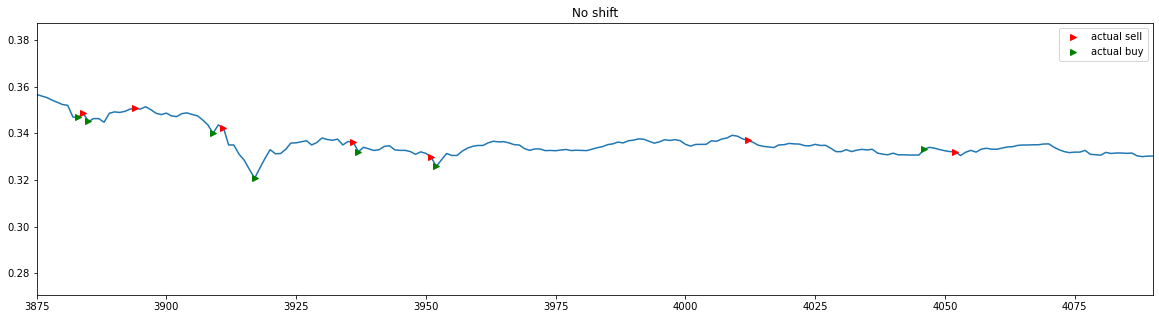

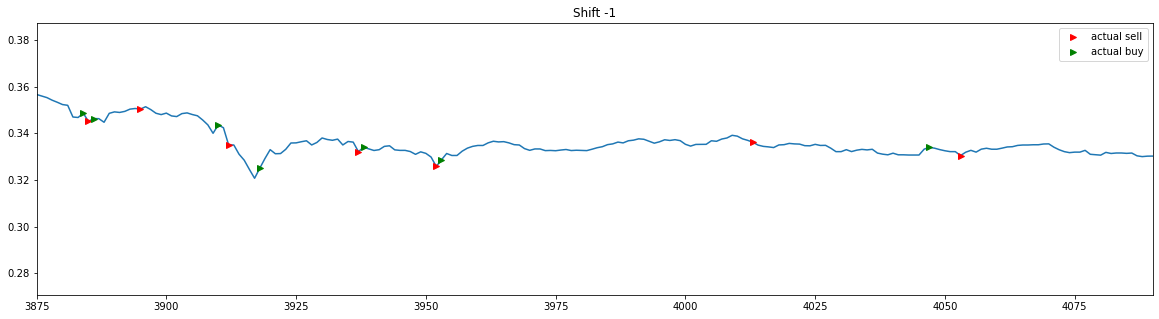

In [28]:
# plotting

xmin=3875
xmax=4090
plt.figure(figsize=(20,5))
plt.plot(df_backtesting_no_shift.open)
plt.plot(df_backtesting_no_shift[df_backtesting_no_shift.action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtesting_no_shift[df_backtesting_no_shift.action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.title("No shift")
plt.xlim([xmin,xmax])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtesting_shift.open)
plt.plot(df_backtesting_shift[df_backtesting_shift.action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtesting_shift[df_backtesting_shift.action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.xlim([xmin,xmax])
plt.title("Shift -1")
plt.show()


In [6]:
metrics = pd.DataFrame(list_results, columns=["threshold", "pair_name", "n_trades", "profit", "hist_ratio"])

In [7]:
metrics.groupby("threshold").profit.mean()

threshold
0.5   -1.735966
1.5    0.480793
2.0    0.583793
2.5    0.577055
3.0    0.564491
3.5    0.525017
4.0    0.482139
Name: profit, dtype: float64

In [86]:
df_test = pd.read_csv(get_project_root() / "data" / "historical" / f"xlmeur.csv")
print(df_test.date.max())
df_test = df_test[df_test.date>cut_off_date]
df_test, _=feature_pipeline(df_test, include_target=False, target_list=[10, 20])
print(df_test.date.max())
n_trades, profit, hist_ratio = backtest(df=df_test, model=model, threshold=3.5, target="target_20", fee=0.0016, columns_features=columns_features)
print(n_trades, profit, hist_ratio)

2021-11-24 15:12:00
2021-11-24 15:12:00
96 0.18410582108176732 -0.07705195257472552


In [85]:
columns_features = [col for col in df_test.columns if col.startswith("feature")]

In [82]:
backtest(df=df_test, model=model, threshold=2.5, target="target_20", fee=0.0024, columns_features=columns_features)

(344, 0.7861254199778113, -0.12882901122092782)

In [84]:
#plt.figure(figsize=(15,5))
#preds = model.predict(df_test[columns_features])
#target = df_test["target_20"]*1000
#plt.plot(preds*10, label="preds")
#plt.plot(target.values, label="target")
##plt.xlim([0,10000])
#plt.legend()
#plt.title("test")
#plt.show()
#print(pd.DataFrame(data={"preds": preds, "target": target}).corr().values[0][1])
#print(r2_score(target,preds ))

In [1]:
#Actual trades
from src.kraken.krakenclient import KrakenClient
api_public_key = open("../API_Public_Key").read().strip()
api_private_key = open("../API_Private_Key").read().strip()
kraken_client = KrakenClient(api_private_key=api_private_key, api_public_key=api_public_key)

In [11]:
dict_closed = kraken_client.get_closed_order_from_start(start_id="OBZX5X-GNUDU-H6HZX3", end_id="OMONJM-2MP4E-2YSLRI")

In [5]:
trades_df = pd.DataFrame({k:v for k,v in dict_closed["result"]["closed"].items() if v["descr"]["pair"]=="ALGOEUR"}).T

In [6]:
trades_df = trades_df.set_index(pd.to_datetime(trades_df["closetm"].astype(int), unit="s"))

In [28]:
trades_df["type"] = [d.get('type') for d in trades_df.descr]
trades_df["price"] = trades_df["price"].astype(float)

In [29]:
trades_df

,refid,userref,status,opentm,starttm,expiretm,descr,vol,vol_exec,cost,fee,price,stopprice,limitprice,misc,oflags,reason,closetm,type
closetm,,,,,,,,,,,,,,,,,,,
2021-11-18 04:50:24,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'buy', 'ordertype'...",20.00000000,20.00000000,38.97980,0.10134,1.94899,0.000000,0.000000,,fciq,None,1.63721e+09,buy
2021-11-18 04:49:17,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'sell', 'ordertype...",20.00000000,20.00000000,38.00000,0.09880,1.90000,0.000000,0.000000,,fciq,None,1.63721e+09,sell
2021-11-18 04:48:41,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'buy', 'ordertype'...",20.00000000,20.00000000,38.83260,0.10096,1.94163,0.000000,0.000000,,fciq,None,1.63721e+09,buy
2021-11-18 04:44:25,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'sell', 'ordertype...",20.00000000,20.00000000,40.63780,0.10565,2.03189,0.000000,0.000000,,fciq,None,1.63721e+09,sell
2021-11-18 04:43:17,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'buy', 'ordertype'...",20.00000000,20.00000000,41.97959,0.10914,2.09897,0.000000,0.000000,,fciq,None,1.63721e+09,buy
2021-11-18 04:37:28,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'sell', 'ordertype...",20.00000000,20.00000000,45.83620,0.11917,2.29181,0.000000,0.000000,,fciq,None,1.63721e+09,sell
2021-11-18 04:36:52,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'buy', 'ordertype'...",20.00000000,20.00000000,45.82520,0.11914,2.29126,0.000000,0.000000,,fciq,None,1.63721e+09,buy
2021-11-18 04:31:34,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'sell', 'ordertype...",20.00000000,20.00000000,48.46900,0.12601,2.42345,0.000000,0.000000,,fciq,None,1.63721e+09,sell
2021-11-18 04:30:58,None,None,closed,1.63721e+09,0,0,"{'pair': 'ALGOEUR', 'type': 'buy', 'ordertype'...",20.00000000,20.00000000,49.40000,0.12844,2.47000,0.000000,0.000000,,fciq,None,1.63721e+09,buy


In [88]:
df_backtesting = df_test.copy()
df_backtesting["preds"] = model.predict(df_test[columns_features])

In [89]:
# backtesting
threshold = 3.5
next_action = "buy"
df_backtesting["action"] = None
df_backtesting["sum"] = None
for index, row in df_backtesting.iterrows():
    if (-row["preds"] > threshold) and (next_action=="buy"):
        df_backtesting.loc[df_backtesting.index==index, "action"] = "buy"
        next_action = "sell"
    elif (-row["preds"] < -threshold) and (next_action=="sell"):
        df_backtesting.loc[df_backtesting.index==index, "action"] = "sell"
        next_action = "buy"


<AxesSubplot:>

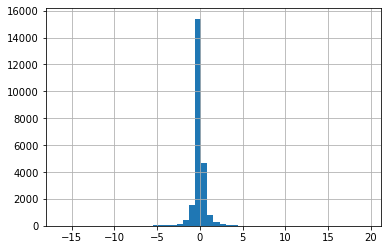

In [90]:
df_backtesting.preds.hist(bins=50)

In [91]:
df_backtesting_dateindex=df_backtesting.set_index(pd.to_datetime(df_backtesting["date"]))

In [92]:
df_backtesting_dateindex.index

DatetimeIndex(['2021-11-08 04:09:00', '2021-11-08 04:10:00',
               '2021-11-08 04:11:00', '2021-11-08 04:12:00',
               '2021-11-08 04:13:00', '2021-11-08 04:14:00',
               '2021-11-08 04:15:00', '2021-11-08 04:16:00',
               '2021-11-08 04:17:00', '2021-11-08 04:18:00',
               ...
               '2021-11-24 15:03:00', '2021-11-24 15:04:00',
               '2021-11-24 15:05:00', '2021-11-24 15:06:00',
               '2021-11-24 15:07:00', '2021-11-24 15:08:00',
               '2021-11-24 15:09:00', '2021-11-24 15:10:00',
               '2021-11-24 15:11:00', '2021-11-24 15:12:00'],
              dtype='datetime64[ns]', name='date', length=23692, freq=None)

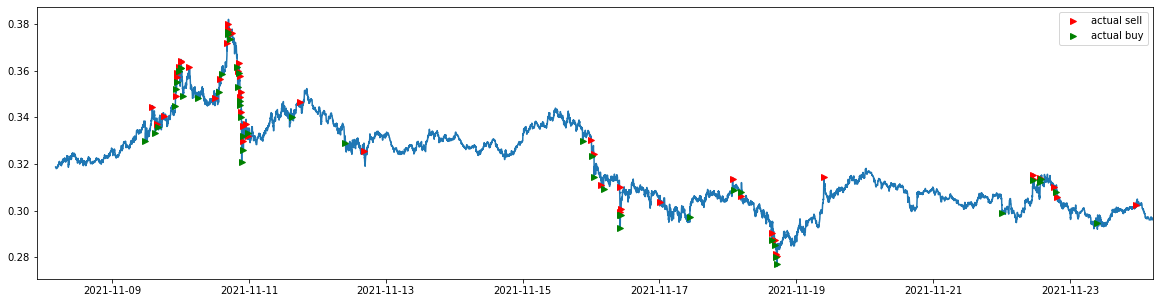

No handles with labels found to put in legend.


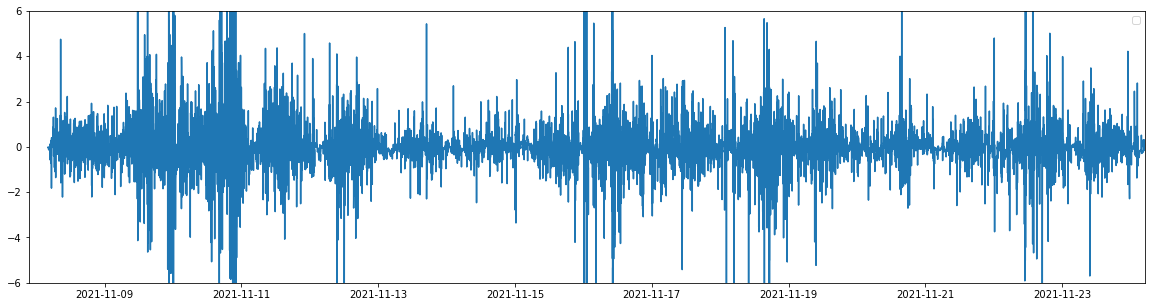

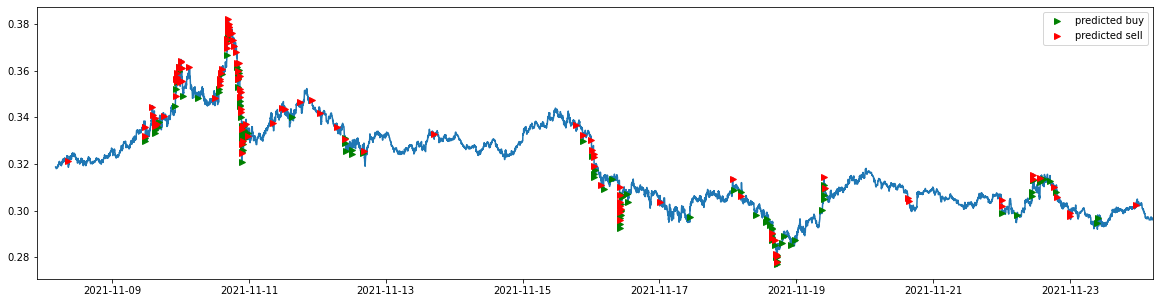

In [94]:
xmin="2021-11-18 04:00"
xmin="2021-11-07 21:28:00"
xmax="2021-11-24 05:00"
plt.figure(figsize=(20,5))
plt.plot(df_backtesting_dateindex.open)
plt.plot(df_backtesting_dateindex[df_backtesting_dateindex.action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtesting_dateindex[df_backtesting_dateindex.action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.xlim([xmin,xmax])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtesting_dateindex.preds, "-")
plt.legend()
plt.xlim([xmin,xmax])
plt.ylim([-6,6])
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtesting_dateindex.open, "-")
plt.plot(df_backtesting_dateindex[-df_backtesting_dateindex.preds> threshold].open, ">g", label="predicted buy")
plt.plot(df_backtesting_dateindex[-df_backtesting_dateindex.preds<-threshold].open, ">r", label="predicted sell")
plt.legend()
plt.xlim([xmin,xmax])

plt.show()
#plt.figure(figsize=(20,5))
#plt.plot(trades_df.price, "-")
#plt.plot(df_backtesting_dateindex.open, "-", label="open")
#plt.plot(df_backtesting_dateindex.low, "-", label="low")
#plt.plot(df_backtesting_dateindex.high, "-", label="high")
#plt.plot(trades_df[trades_df.type=="sell"].price, ">r", label="actual sell")
#plt.plot(trades_df[trades_df.type=="buy"].price, ">g", label="actual buy")
#plt.legend()
#plt.xlim([xmin,xmax])
#plt.show()

In [101]:
df_backtesting_dateindex[df_backtesting_dateindex.action.notnull()]

,date,time,open,high,low,close,vwap,volume,count,open_norm,...,feature_domain_31,feature_domain_32,feature_domain_33,feature_domain_34,feature_domain_35,feature_domain_36,feature_domain_37,preds,action,sum
date,,,,,,,,,,,,,,,,,,,,,
2021-11-09 11:39:00,2021-11-09 11:39:00,1636457940,0.329869,0.331464,0.329867,0.331172,0.330325,49215.590935,23,1.0,...,-0.021816,-0.019706,-0.019123,-0.011504,-0.004812,0.001427,0.006137,-4.136319,buy,None
2021-11-09 14:03:00,2021-11-09 14:03:00,1636466580,0.344500,0.344501,0.343045,0.343045,0.343829,173626.032745,19,1.0,...,0.017689,0.026948,0.034146,0.040129,0.023671,0.030789,0.042398,4.949998,sell,None
2021-11-09 15:08:00,2021-11-09 15:08:00,1636470480,0.333295,0.335000,0.333215,0.334648,0.334422,152490.822808,31,1.0,...,-0.026051,-0.018022,-0.031119,-0.010248,0.006803,-0.002191,0.000712,-4.641719,buy,None
2021-11-09 15:50:00,2021-11-09 15:50:00,1636473000,0.336912,0.336912,0.335329,0.335329,0.336370,2806.073208,11,1.0,...,-0.004132,0.003951,-0.011368,-0.023070,0.013184,0.000627,0.008616,4.073425,sell,None
2021-11-09 16:04:00,2021-11-09 16:04:00,1636473840,0.335757,0.337406,0.335757,0.337406,0.336450,1023.864956,4,1.0,...,-0.003487,-0.004291,-0.005571,-0.013121,0.004506,-0.005164,0.005209,-4.542596,buy,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-22 19:02:00,2021-11-22 19:02:00,1637607720,0.307958,0.309298,0.307958,0.309298,0.308898,9384.292990,6,1.0,...,-0.001375,-0.008627,-0.009345,-0.012544,-0.017919,-0.022179,-0.000136,-4.170297,buy,None
2021-11-22 19:37:00,2021-11-22 19:37:00,1637609820,0.305876,0.305876,0.304000,0.304000,0.305318,1488.567861,16,1.0,...,-0.015352,-0.007846,-0.007821,-0.016606,-0.023690,-0.018092,-0.012988,5.015578,sell,None
2021-11-23 09:40:00,2021-11-23 09:40:00,1637660400,0.294659,0.296453,0.294659,0.296453,0.294787,20776.852947,12,1.0,...,-0.004621,-0.001860,0.004938,0.002238,-0.011722,-0.021135,-0.009050,-5.698355,buy,None


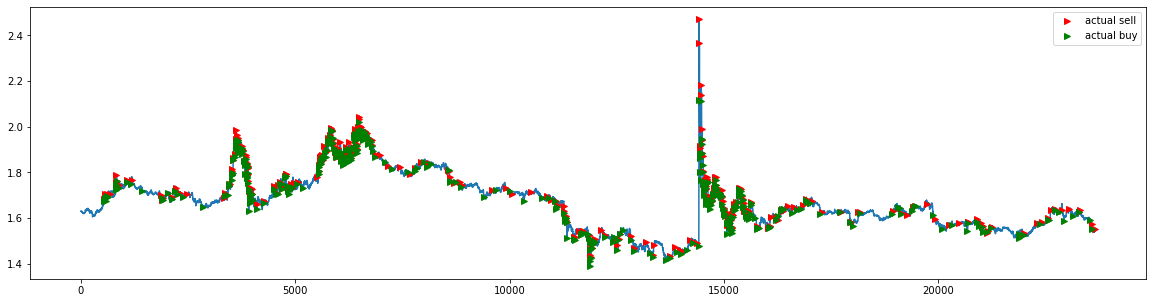

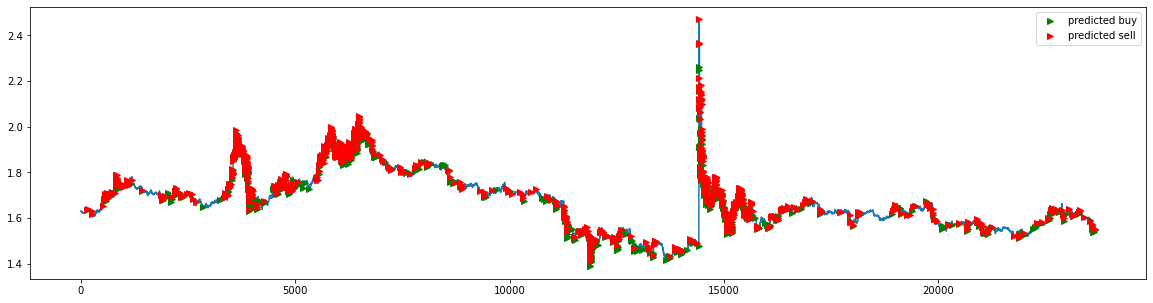

In [41]:
#plt.plot(df_backtesting.preds)
#plt.plot(df_backtesting.target_10)
plt.figure(figsize=(20,5))
plt.plot(df_backtesting.open)
plt.plot(df_backtesting[df_backtesting.action=="sell"].open, ">r", label="actual sell")
plt.plot(df_backtesting[df_backtesting.action=="buy"].open, ">g", label="actual buy")
plt.legend()
plt.show()
plt.figure(figsize=(20,5))
plt.plot(df_backtesting.open, "-")
plt.plot(df_backtesting[-df_backtesting.preds> threshold].open, ">g", label="predicted buy")
plt.plot(df_backtesting[-df_backtesting.preds<-threshold].open, ">r", label="predicted sell")
#plt.xlim([0,1000])
#plt.ylim([4050,4150])
plt.legend()
plt.show()

In [102]:
df_backtesting["sum"] = None
fee = 0.0024
df_backtesting.loc[(df_backtesting.action=="buy"), "sum"] = -df_backtesting[df_backtesting.action=="buy"].open*(1+fee)
df_backtesting.loc[(df_backtesting.action=="sell"), "sum"] = df_backtesting[df_backtesting.action=="sell"].open*(1-fee)

In [103]:
if df_backtesting[df_backtesting.action.notnull()].tail(1).action.values[0]=="buy":
    df_backtesting.loc[df_backtesting[df_backtesting.action.notnull()].tail(1).index, ["sum", "action"]] = None
if df_backtesting[df_backtesting.action.notnull()].tail(1).action.values[0]=="buy":
    raise ValueError("last action cannot be buy")
df_backtesting["sum"].notnull().sum()

96

In [104]:
df_backtesting[df_backtesting.action.notnull()].tail(1)["action"]

22720    sell
Name: action, dtype: object

In [105]:
df_backtesting[df_backtesting.action.notnull()][["open","high", "low", "preds", "action", "sum"]]

,open,high,low,preds,action,sum
1890,0.329869,0.331464,0.329867,-4.136319,buy,-0.330661
2034,0.344500,0.344501,0.343045,4.949998,sell,0.343673
2099,0.333295,0.335000,0.333215,-4.641719,buy,-0.334095
2141,0.336912,0.336912,0.335329,4.073425,sell,0.336103
2155,0.335757,0.337406,0.335757,-4.542596,buy,-0.336563
...,...,...,...,...,...,...
21013,0.310000,0.310000,0.308568,4.025704,sell,0.309256
21041,0.307958,0.309298,0.307958,-4.170297,buy,-0.308697
21076,0.305876,0.305876,0.304000,5.015578,sell,0.305142
21919,0.294659,0.296453,0.294659,-5.698355,buy,-0.295366


In [106]:
df_backtesting["sum"].sum()

0.11269312400000148

In [264]:
df.date.max()

'2021-11-16 13:54:00'